In [1]:
# importing libraries
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy
import scipy.spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
from tqdm import tqdm
import imgaug.augmenters as iaa
from natsort import natsorted
%matplotlib inline

In [2]:
# function to create density maps for images
def gaussian_filter_density(gt):
    print (gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(list(zip(np.nonzero(gt)[1], np.nonzero(gt)[0])))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print ('generate density...')
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.05
            #print((distances[i][1]+distances[i][2]+distances[i][3])*0.1, sigma)
            if sigma == float("inf"):
                sigma = 10
            #print(sigma)
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print ('done.')
    return density

In [33]:
#set the root to the Shanghai dataset you download
root = "counting/dataset"

In [37]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,"train","images")
part_A_test = os.path.join(root,"test","images")
path_sets = [part_A_test]#, part_A_test]

In [38]:
img_paths = []
for path in path_sets:
    #for img_path in glob.glob(os.path.join(path, "*.jpg")):
    for img_path in natsorted(glob.glob(os.path.join(path, "*.jpg"))):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths[69:125]:
    print (img_path)
    
    try:
        mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground-truth').replace('IMG_','GT_IMG_'))
        img= plt.imread(img_path)
        k = np.zeros((img.shape[0],img.shape[1]))
        gt = mat["image_info"][0,0][0,0][0]

        for i in range(0,len(gt)):
            if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
                k[int(gt[i][1]),int(gt[i][0])]=1
        k = gaussian_filter_density(k)
        with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground-truth'), 'w') as hf:
                hf['density'] = k
    except Exception as e:
        print(e)

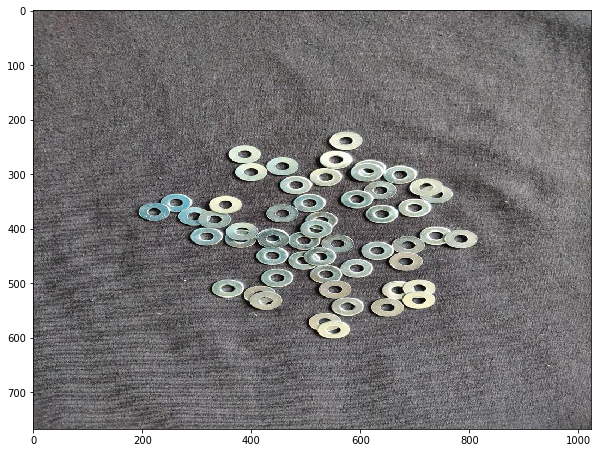

In [41]:
#now see a sample from ShanghaiA
fig = plt.figure(figsize=(10, 10))
plt.imshow(Image.open(part_A_test + '/IMG_3.jpg'))
plt.show()

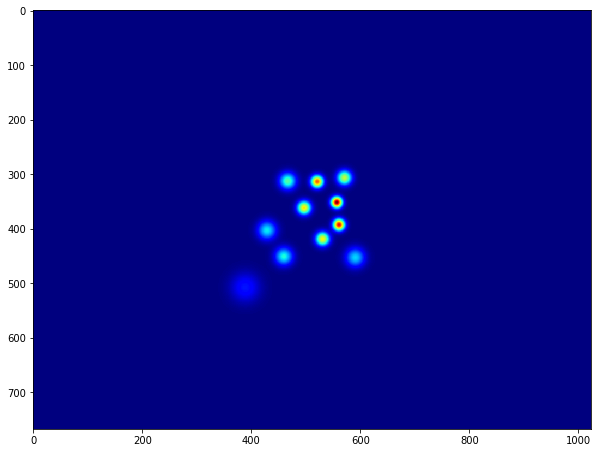

In [44]:
fig = plt.figure(figsize=(10, 10))
gt_file = h5py.File((part_A_test + '/IMG_4.jpg'.replace('.jpg','.h5')).replace('images','ground-truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
plt.show()

In [ ]:
np.round(np.sum(groundtruth), 2)

In [ ]:
img_paths

In [ ]:
from scipy.ndimage import rotate
import scipy
import imageio

num = 1760
for i in img_paths[69:125]:
    print (i)
    
    try:
        gt_file = h5py.File(i.replace('.jpg','.h5').replace('new_images','ground-truth'),'r')
        groundtruth = np.asarray(gt_file['density'])
        img = plt.imread(i)
        #for angle in [-10, -20, -30, -45, -60, 10, 20, 30, 45, 60, 245, 120]:
        for angle in [-30, -60, 30, 60, 245, 120]:
                image = rotate(img, angle, reshape=False)
                old_image_name = i.split('/')[-1]
                new_image_name = i.replace(old_image_name, "IMG_"+str(num)+".jpg")
                print(new_image_name)
                imageio.imwrite(new_image_name, image)
                new_gt_name = new_image_name.replace('.jpg','.h5').replace('new_images','ground-truth')
                gt = rotate(groundtruth, angle, reshape=False)
                print(new_gt_name)

                with h5py.File(new_image_name.replace('.jpg','.h5').replace('new_images','ground-truth'), 'w') as hf:
                    hf['density'] = gt
                num +=1
        
    except Exception as e:
        print(e)

